<a href="https://colab.research.google.com/github/kweteM/MyColabProjects/blob/main/FakeNews_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1 IMPORT LIBRARIES**

Importing needed dependencies:

* Pandas
* Numpy
* spaCy
* Re
* Scikit Learn

In [22]:
import pandas as pd                                                   # A library to handle our (CSV file) tabular data.
import numpy as np                                                    # A library to provide numerical computing support.
import spacy                                                          # A library for text preprocessing.
import re                                                             # A built-in module to provide regular expressions for text cleaning.
from sklearn.model_selection import train_test_split                  # A sub-module of scikit learn to split the dataset into training and testing subsets.
from sklearn.feature_extraction.text import TfidfVectorizer           # A sub-module of scikit learn to convert text data into numerical features
from sklearn.metrics import accuracy_score, classification_report     # A sub-module of scikit learn to evaluate the model performance and generate the report

In [3]:
# Load small spaCy's English model for NLP preprocessing. It contains the tools for text preprocessing
nlp = spacy.load("en_core_web_sm")

**2 Load Dataset**

In [4]:
# Load dataset and read te dataset
data = pd.read_csv("/content/sample_data/fake_and_real_news.csv")

In [5]:
# Print first five rows of the dataset
data.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


**3. Data Inspecting/Profiling**

In [8]:
# Check all the columns of the dataset
print(data.columns)

Index(['Text', 'label'], dtype='object')


In [9]:
# Check the number of rows and columns
data.shape

(9900, 2)

In [10]:
# Check for null values
data.isnull().sum()

,0
Text,0
label,0


In [11]:
# Check for NaN values
data.isna().sum()

,0
Text,0
label,0


In [13]:
# Check for duplicate values
data.duplicated().sum()

35

In [16]:
# Check the class balance

checked = data["label"].value_counts(normalize=True) * 100
checked = checked.round(2).astype(str) + "%"
print(checked)

label
Fake    50.51%
Real    49.49%
Name: proportion, dtype: object


This column has one class that makes up 0.5 something % less. So, this is not an imbalanced data.

**4. Data Preprocessing & Cleaning**

In [17]:
# Convert labels to numerical values: 'Fake' -> 0, 'Real' -> 1
data['label'] = data['label'].map({'Fake': 0, 'Real': 1})

In [18]:
# Check the change
data.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,0
1,U.S. conservative leader optimistic of common ...,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",1
3,Court Forces Ohio To Allow Millions Of Illega...,0
4,Democrats say Trump agrees to work on immigrat...,1


In [19]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters & numbers
    return text

In [20]:
# Function to preprocess text
def preprocess_text(text):
    text = clean_text(text)  # Apply cleaning
    doc = nlp(text.lower())  # Convert to lowercase and tokenize
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] # Apply lemmatization, remove stop words & punctuations
    return " ".join(words)  # Convert list back to string

In [21]:
# Apply cleaness and preprocessing on the Text column
data['cleaned_text'] = data['Text'].apply(preprocess_text)

In [23]:
# Print the cleaned and preprocessed Text column
print(data[['Text', 'cleaned_text']].head())

                                                Text  \
0   Top Trump Surrogate BRUTALLY Stabs Him In The...   
1  U.S. conservative leader optimistic of common ...   
2  Trump proposes U.S. tax overhaul, stirs concer...   
3   Court Forces Ohio To Allow Millions Of Illega...   
4  Democrats say Trump agrees to work on immigrat...   

                                        cleaned_text  
0    trump surrogate brutally stab s pathetic vid...  
1  conservative leader optimistic common ground h...  
2  trump propose tax overhaul stir concern defici...  
3    court force ohio allow million illegally pur...  
4  democrats trump agree work immigration bill wa...  


**5. Data Reduction**

In [35]:
data2 = data.copy() # Copy the data before proceeding to drop the duplicate values
data2.duplicated().sum()

35

In [36]:
# Drop the duplicate values to avoid model overfitting
data2.drop_duplicates(inplace=True)
data2.duplicated().sum()

0

**6. Featuring Engineering**

In [28]:
# TF-IDF Vectorization: convert the data into numerical vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data2['cleaned_text'])
y = data2['label'].values

**7. Model Selection**

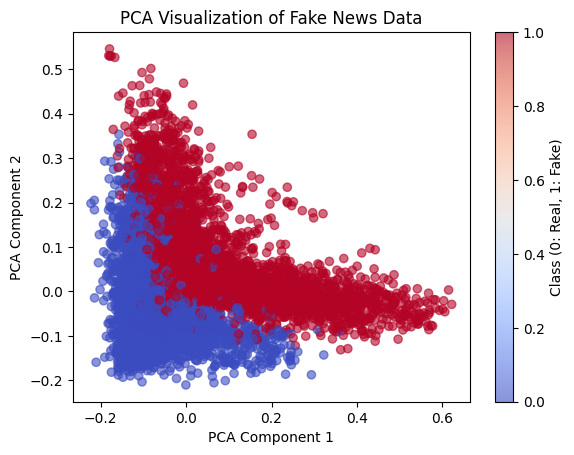

In [29]:
# Checking for Linearity to decide on classfication model choice
# Visualize data using PCA (Principal Component Analysis) or t-SNE.

'''If the classes are separable by a straight line → Dataset is linear.
If they overlap significantly and form complex patterns → Dataset is non-linear'''

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert the sparse matrix to a dense array
X_dense = X.toarray()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Fake News Data")
plt.colorbar(label="Class (0: Real, 1: Fake)")
plt.show()

In [30]:
# Split dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is less non-linear:
Logistic Regression can be used since it is the simple, interpretable, and efficient on small datasets for binary class.

In [31]:
from sklearn.linear_model import LogisticRegression # A sub-module of scikit learn to provide Logistic Regression class

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [32]:
# Predictions
y_pred = model.predict(X_test)

In [33]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9909
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       977
           1       0.99      0.99      0.99       996

    accuracy                           0.99      1973
   macro avg       0.99      0.99      0.99      1973
weighted avg       0.99      0.99      0.99      1973

